# Introduction:

Redhat has gathered large amount of information about its costumer behavior. The purpose of this project is to use these information to build a model that predicts which costumer has the most potential for business for Redhat.
This notebook is dedicated to solving the Redhat business kaggle competition. 
I will try to put some notes here and there to make it readable, while not to busy so that you might lose the big pitcure.

This task has put as a competition on Kaggle. You can learn more about the competition [here](https://www.kaggle.com/c/predicting-red-hat-business-value), and about the data [here](https://www.kaggle.com/c/predicting-red-hat-business-value/data).

# Importing Packages

Four main data mining packages is imported beside several packages used for specific tasks. These four packages are [pandas](https://pandas.pydata.org/), [numpy](http://www.numpy.org/), [matplotlib](https://matplotlib.org/), [sikit-learn](http://scikit-learn.org/stable/).

I have gathered and uploaded many cheat sheets for these packages along with other packages that would come very handy. Look [here](https://github.com/amnghd/DS-Cheat_sheets) for more information.



In [40]:
from datetime import datetime
from calendar import Calendar
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
plt.style.use('ggplot')
from dateutil.parser import parse
from scipy.stats import chi2_contingency
import random
from scipy import fftpack
from statsmodels.graphics.mosaicplot import mosaic
from sklearn.cross_validation import LabelKFold
import xgboost as xgb

# Imorting Data

"This competition uses two separate data files that may be joined together to create a single, unified data table: a people file and an activity file.

The people file contains all of the unique people (and the corresponding characteristics) that have performed activities over time. Each row in the people file represents a unique person. Each person has a unique people_id.

The activity file contains all of the unique activities (and the corresponding activity characteristics) that each person has performed over time. Each row in the activity file represents a unique activity performed by a person on a certain date. Each activity has a unique activity_id."

We parse the date columns to make a datetime index available. Moreover, we suffix each dataframe to assure naming would not be confusing.

In [41]:
act_train = pd.read_csv('data/act_train.csv.zip', parse_dates=['date'])
act_test = pd.read_csv('data/act_test.csv.zip', parse_dates=['date'])
activity = [act_train, act_test]
people = pd.read_csv('data/people.csv.zip', parse_dates=['date'])
combine = [pd.merge(dataframe,people, on='people_id', how='left',suffixes=['_act','_ppl']) for dataframe in activity]
train=combine[0]
test=combine[1]

## Exploratory Data Analysis:

Before building any model, we need to get high-level perspective of the data. This is done through exploratory data analysis (EDA) and visualized exploratory data analysis (VEDA).
The main tolls for EDA are **shape, head, tail, describe, info, dtypes, groupby** methods.

In [42]:
print("This training data set has \"{}\" observations and \"{}\" variables.".format(combine[0].shape[0],train.shape[1]))

This training data set has "2197291" observations and "55" variables.


In [43]:
train.head()

,people_id,activity_id,date_act,activity_category,char_1_act,char_2_act,char_3_act,char_4_act,char_5_act,char_6_act,...,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38
0,ppl_100,act2_1734928,2023-08-26,type 4,NaN,NaN,NaN,NaN,NaN,NaN,...,False,True,True,False,False,True,True,True,False,36
1,ppl_100,act2_2434093,2022-09-27,type 2,NaN,NaN,NaN,NaN,NaN,NaN,...,False,True,True,False,False,True,True,True,False,36
2,ppl_100,act2_3404049,2022-09-27,type 2,NaN,NaN,NaN,NaN,NaN,NaN,...,False,True,True,False,False,True,True,True,False,36
3,ppl_100,act2_3651215,2023-08-04,type 2,NaN,NaN,NaN,NaN,NaN,NaN,...,False,True,True,False,False,True,True,True,False,36
4,ppl_100,act2_4109017,2023-08-26,type 2,NaN,NaN,NaN,NaN,NaN,NaN,...,False,True,True,False,False,True,True,True,False,36


Out of these 55 variables, "outcome" column is the target (response, dependant) variable and the remaining "53" variables are feature (explanatory) variables. The activity_id is also chosen as the index variable. By index variable we mean that it is the identifying variable of the test set. Therefore it is unique and non-contributing to the feature analysis. 

We also see what is the data type of each of the variables. We use the info method for this purpose. info method summarizes its results for large dataset, therefore we randomly select 100,000 observations.

In [44]:
train.iloc[random.sample(range(1, 2000000), 100000)].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 108732 to 1075865
Data columns (total 55 columns):
people_id            100000 non-null object
activity_id          100000 non-null object
date_act             100000 non-null datetime64[ns]
activity_category    100000 non-null object
char_1_act           7180 non-null object
char_2_act           7180 non-null object
char_3_act           7180 non-null object
char_4_act           7180 non-null object
char_5_act           7180 non-null object
char_6_act           7180 non-null object
char_7_act           7180 non-null object
char_8_act           7180 non-null object
char_9_act           7180 non-null object
char_10_act          92820 non-null object
outcome              100000 non-null int64
char_1_ppl           100000 non-null object
group_1              100000 non-null object
char_2_ppl           100000 non-null object
date_ppl             100000 non-null datetime64[ns]
char_3_ppl           100000 non-null object
char_4_

Looking at the results of this table, we can see that features char_1_act to char_9_act have values for less than 8% of the data. Therefore, they are good candidates for being removed from the data set in case we are facing overfitting. 

Now let's learn about the outcome variable; what is its data type and possible values? Moreovere, what is the base rate of classification (is data skewed? do we need to use metrics other than accuracy?)

In [45]:
print("The target column ('outcome) is of data type \"{}\" (numeric) and\
it has \"{}\" categories which are: \"{}\""\
.format(train.outcome.dtype,train.outcome.dropna().unique().size,train.outcome.dropna().unique()))

The target column ('outcome) is of data type "int64" (numeric) andit has "2" categories which are: "[0 1]"


In [46]:
print("The base rate of the classification (percentage of positive category) is %{0:.2f}".format(100*train.outcome.mean()))

The base rate of the classification (percentage of positive category) is %44.40


Now we take a thorough look at the feature variables. What are their data types, and their statistics. First let's get the statistics of the numerical data. For that we use the **describe** method. It by default only returns the numerical values.

In [47]:
train.describe()

,outcome,char_38
count,2.197291e+06,2.197291e+06
mean,4.439544e-01,4.998051e+01
std,4.968491e-01,3.608557e+01
min,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00
50%,0.000000e+00,5.900000e+01
75%,1.000000e+00,8.200000e+01
max,1.000000e+00,1.000000e+02


It seems that the char_38 variable is a perrcentage. It starts from 0 and goes to 100. Its mean value is 50 and its standard deviation is 36.

Now let's look at the categorial variables' statistics. By including ['O'] in the describe method we can get the description of categorical features.

In [48]:
train.describe(include=['O'])

,people_id,activity_id,activity_category,char_1_act,char_2_act,char_3_act,char_4_act,char_5_act,char_6_act,char_7_act,...,char_1_ppl,group_1,char_2_ppl,char_3_ppl,char_4_ppl,char_5_ppl,char_6_ppl,char_7_ppl,char_8_ppl,char_9_ppl
count,2197291,2197291,2197291,157615,157615,157615,157615,157615,157615,157615,...,2197291,2197291,2197291,2197291,2197291,2197291,2197291,2197291,2197291,2197291
unique,151295,2197291,7,51,32,11,7,7,5,8,...,2,29899,3,43,25,9,7,25,8,9
top,ppl_294918,act2_4302714,type 2,type 2,type 2,type 1,type 3,type 6,type 2,type 1,...,type 2,group 17304,type 3,type 40,type 25,type 9,type 1,type 8,type 3,type 3
freq,55103,1,904683,38030,50524,38224,98131,67989,61026,52548,...,1991452,799125,1192327,697260,697260,697260,723095,263444,925643,972575


- We have 23 categorical variables.
- The category names are usually a name followed by "_" or a space and unique number. This observation comes in handy later for the feature engineering. 
- We can see that activity_id is unique for each entry, while people_id can repeat more than one, implying on how many activities the indivdual has had. Moreover, we notice that in total we have 7 categories.

Now let's take at the boolean parameters. These are categories with two values that are set as True or False.

In [49]:
train.describe(include=[bool])

,char_10_ppl,char_11,char_12,char_13,char_14,char_15,char_16,char_17,char_18,char_19,...,char_28,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37
count,2197291,2197291,2197291,2197291,2197291,2197291,2197291,2197291,2197291,2197291,...,2197291,2197291,2197291,2197291,2197291,2197291,2197291,2197291,2197291,2197291
unique,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
top,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
freq,1667159,1743501,1681367,1429402,1636690,1621615,1607842,1582675,1807392,1601399,...,1599986,1838811,1749461,1607379,1608414,1726900,1437466,1754908,1475996,1602193


- We have 28 boolean variables. 
- False is the more repeated outcome.

Another very important aspect to consider is the date time variables. There is one "date" for each dataset and are available in both activity and people datasets.

In [50]:
combine[0][['date_ppl','date_act']].describe()

,date_ppl,date_act
count,2197291,2197291
unique,1196,411
top,2022-03-02 00:00:00,2022-09-30 00:00:00
freq,55371,48174
first,2020-05-18 00:00:00,2022-07-17 00:00:00
last,2023-08-31 00:00:00,2023-08-31 00:00:00


Oddly, these two datasets have different time frames. The people dataset starts from June 2020 and goes to August 2023. However, the activity dataset starts from July 2022 and goes to August 2023.

## Visualized Exploratory Data Analysis:

Let's see how outcome changes over time. We take time series analysis to use. We use resampling over month to see the average outcome, number of transactions, and number of successful transaction. We draw the number of successful transaction as a business intelligent.

In [51]:
date_act_series = combine[0][['date_act', 'outcome']].set_index('date_act')
date_ppl_series = combine[0][['date_ppl', 'outcome']].set_index('date_ppl')

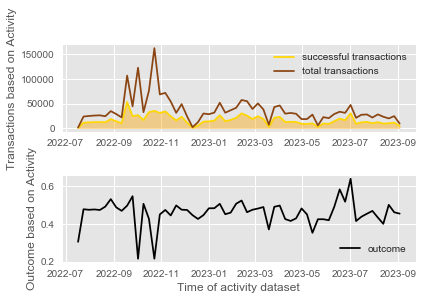

In [52]:
date_act_mean = date_act_series.resample('W').mean()
date_act_count = date_act_series.resample('W').count()
date_act_successfull = date_act_mean*date_act_count
plt.subplot(211)
plt.plot(date_act_successfull.index,date_act_successfull, color='gold', label = 'successful transactions')
plt.plot(date_act_successfull.index,date_act_count, color='saddlebrown', label = 'total transactions')
plt.fill_between(date_act_successfull.index,(date_act_successfull.outcome), alpha=0.4, color='orange')
plt.ylabel('Transactions based on Activity')
plt.legend()
plt.subplot(212)
plt.plot(date_act_successfull.index,date_act_mean, color='black', label = 'outcome')
plt.tight_layout()
plt.ylabel('Outcome based on Activity')
plt.xlabel('Time of activity dataset')
plt.legend()

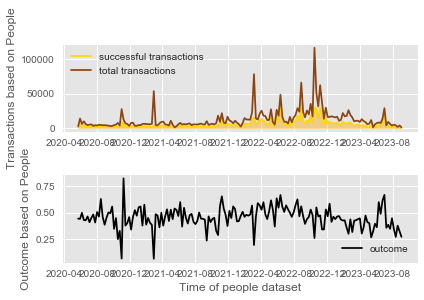

In [53]:
date_ppl_mean = date_ppl_series.resample('W').mean()
date_ppl_count = date_ppl_series.resample('W').count()
date_ppl_successfull = date_ppl_mean*date_ppl_count
plt.subplot(211)
plt.plot(date_ppl_successfull.index,date_ppl_successfull, color='gold', label = 'successful transactions')
plt.plot(date_ppl_successfull.index,date_ppl_count, color='saddlebrown', label = 'total transactions')
plt.fill_between(date_ppl_successfull.index,(date_ppl_successfull.outcome), alpha=0.4, color='orange')
plt.ylabel('Transactions based on People')
plt.legend()
plt.subplot(212)
plt.plot(date_ppl_successfull.index,date_ppl_mean, color='black', label = 'outcome')
plt.tight_layout()
plt.ylabel('Outcome based on People')
plt.xlabel('Time of people dataset')
plt.legend()

Now, let's take a look at the time series in more details and with zooming capabilities. We are going to use bokeh package.

In [54]:
from bokeh.io import show, output_notebook
from bokeh.plotting import figure
from bokeh.layouts import column
p1 = figure(plot_width =600,plot_height=300, x_axis_type = 'datetime', x_axis_label='Date', y_axis_label='Number of Transactions')
p1.line(x=date_ppl_successfull.index, y=date_ppl_successfull.outcome, legend='successfull')
p1.line(x=date_ppl_count.index, y=date_ppl_count.outcome, color='red',legend='total')
p1.legend.location ='top_left'
p1.legend.background_fill_color = 'lightgray'
output_notebook()
show(p1)

Loading BokehJS ...

There seems to be a general periodic behaviour in outcome, against both date_ppl and date_act values. We can quantify this periodicity using [Fourier series](http://mathworld.wolfram.com/FourierSeries.html). "A Fourier series is an expansion of a periodic function f(x) in terms of an infinite sum of sines and cosines". We have imported fftpack from scipy for the purpose of extracting periodical behaviour of the data.

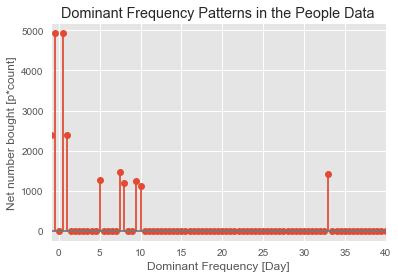

In [55]:
date_act_mean_daily = date_ppl_series.resample('D').mean()
date_act_count_daily = date_ppl_series.resample('D').count()
date_act_successfull_daily = date_ppl_mean*date_ppl_count
x = date_act_successfull_daily['outcome'].tolist()
X = fftpack.fft(x-np.mean(x))
N = len(x)
freqs = fftpack.fftfreq(N) * 1 
dominants = np.array([val if val>1100 else 0 for val in np.abs(X)*2/N])
plt.stem(freqs*N/2,dominants )
plt.xlim([-1,40])
plt.xlabel('Dominant Frequency [Day]')
plt.ylabel('Net number bought [p*count]')
plt.title('Dominant Frequency Patterns in the People Data')
plt.show()

We can (roughly) see that there is a dominant frequence close to 7 days, and one close to 33 days. Since the data is not stationary (when we see transients inside a periodic waveform, we call it non-stationary), the fourier series is not a precise presentation of periodicity. There are other techniques used for such purpose, such as [Time-Frequency](https://en.wikipedia.org/wiki/Bilinear_time%E2%80%93frequency_distribution) distribution. However, for the purpose of visualization, the current waveform shows enough information on:

1. There is a repititive behaviour weekly.
2. There is a repititive behaviour monthly (33 days)

### Numerical Variable (char_38)
Now we want to further perform VEDA on our single numeric ``char_38`` variable and see its relationship with our target. When our target is categorical and our fature is numerical, several gaphs are useful, e.g. boxplot. Here we use seaborn's violin plot which is a combination of kernel density and box plot.

C:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


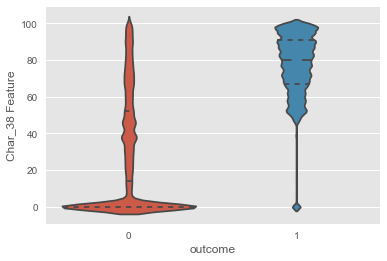

In [56]:
sns.violinplot(data=combine[0], y='char_38', x='outcome',inner="quartile")
plt.ylabel('Char_38 Feature')
plt.legend(loc='center')
plt.show()

This is a quite informative feature. As can be seen from the graph, success (outcome=1) is highly correlated with large_char38 s. The exact opposite goes to failure (outcome=0).

#### Categorical Variables:

Now let's take a look at the categorical variables. One of the best ways to represent the relationship between a categorial feature and a categorical target is mosaic plot. Mosaic plot is similar to relative frequency bar plot. However, it also takes into account the size of the target feature. There are many categorical features in this data set. I will study a couple of them that show a high correlation with the target variable.

###### Char_16

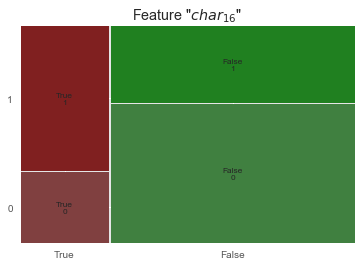

In [57]:
mosaic(combine[0], ['char_16','outcome'], title ='Feature "$char_{16}$"')
plt.ylabel('outcome')

This feature also demonstrates that it correlates largely with the output classes.

##### char_6_ppl

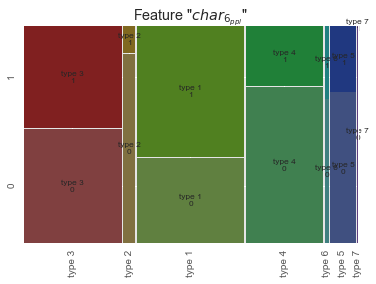

In [58]:
mosaic(combine[0], ['char_6_ppl','outcome'], title ='Feature "$char_{6_{ppl}}$"', label_rotation=90)
plt.ylabel('outcome')

This categorical feature also shows some variations with the outcome column.


Some of the categorical features have some correlation. We need to make sure there is not large correlation between two categorical features. Let's use the heatmap. But before that let's get a list of fatuers with different data types.

In [59]:
g = combine[0].columns.to_series().groupby(combine[0].dtypes).groups
bool_features = ['char_10_ppl', 'char_11', 'char_12', 'char_13', 'char_14', 'char_15',
        'char_16', 'char_17', 'char_18', 'char_19', 'char_20', 'char_21',
        'char_22', 'char_23', 'char_24', 'char_25', 'char_26', 'char_27',
        'char_28', 'char_29', 'char_30', 'char_31', 'char_32', 'char_33',
        'char_34', 'char_35', 'char_36', 'char_37']
catg_features = ['people_id', 'activity_id', 'activity_category', 'char_1_act',
        'char_2_act', 'char_3_act', 'char_4_act', 'char_5_act', 'char_6_act',
        'char_7_act', 'char_8_act', 'char_9_act', 'char_10_act', 'char_1_ppl',
        'group_1', 'char_2_ppl', 'char_3_ppl', 'char_4_ppl', 'char_5_ppl',
        'char_6_ppl', 'char_7_ppl', 'char_8_ppl', 'char_9_ppl']

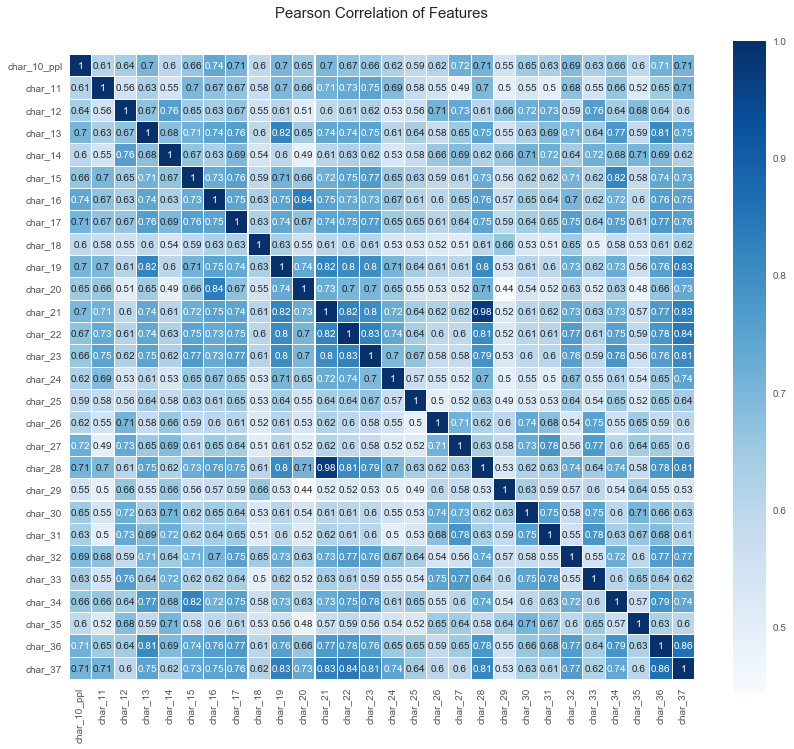

In [60]:
colormap=plt.cm.Blues
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(combine[0][bool_features].astype('float').corr(), linewidths=0.1, vmax=1, square=True, cmap=colormap, linecolor='white', annot=True)
plt.savefig('boolean_correlation')
plt.show()

The following features can be considered correlated (higher than 80% correlation)
- char_37 with char_19, char_21, char_22, char_23, char_28, char_36
- char_36 with char_12
- char_34 with char_15
- char_28 with char_19, char_21, char_22
- char_19 with char_22, char_23, char_21
- char_20 with char_16
- char_19 with char_13

In [61]:
correlated_features = ['char_19', 'char_21', 'char_22', 'char_23',
                       'char_28', 'char_36', 'char_12', 'char_34',
                      'char_15', 'char_16', 'char_13']

These features might be good candidates for dropping out in case we face overfitting. According to this [thread](https://stats.stackexchange.com/questions/234668/how-should-i-deal-with-highly-correlated-features), since our data size is large enough, we can neglect the fact that several features are highly correlated.

#### Data Cleaning:
There are many columns that have large portion of NANs, for example 93% of column char_1_x is missing. We are going to remove columns with more than 30% null values.

In [62]:
print("{0:.1f}%".format(100*(combine[0].char_1_act.isnull().sum())/len(combine[0].char_1_act)))

92.8%


In [63]:
threshold = round (0.7*combine[0].shape[0])
available_data_columns = combine[0].dropna(axis = 'columns', thresh = threshold).columns.values
available_data_columns = set(available_data_columns)
columns_to_keep = available_data_columns - set(correlated_features)
print("In case we face overfitting, we can use only features in\
 columns_to_keep set, that includes {} fatures.".format(len(columns_to_keep)))
#combine[0] = combine[0][columns_to_keep]# only keep these features for training
#combine[1] = combine[1][[column for column in columns_to_keep if column!='outcome']]# test doesnt have outcome


In case we face overfitting, we can use only features in columns_to_keep set, that includes 35 fatures.


#### Feature Engneering

We are going to add for fatures to the existing features. These include, weekday, and month of the year for both date_ppl and data_act time indices.

In [64]:
for dataframe in combine:
    dataframe['Month_act'] = dataframe['date_act'].apply(lambda x:datetime.date(x).month)
    dataframe['Month_ppl'] = dataframe['date_ppl'].apply(lambda x:datetime.date(x).month)
    dataframe['Weekday_act'] = dataframe['date_act'].apply(lambda x:datetime.date(x).weekday())
    dataframe['Weekday_ppl'] = dataframe['date_ppl'].apply(lambda x:datetime.date(x).weekday())


Let's see if these new features are informative.

In [65]:
combine[0][['Month_act','outcome']].groupby('Month_act', as_index=False).mean().sort_values(by='Month_act',ascending=False)

,Month_act,outcome
11,12,0.465538
10,11,0.470517
9,10,0.345893
8,9,0.384952
7,8,0.474948
6,7,0.477664
5,6,0.543720
4,5,0.401292
3,4,0.433576
2,3,0.488058


In [66]:
combine[0][['Month_ppl','outcome']].groupby('Month_ppl', as_index=False).mean().sort_values(by='Month_ppl',ascending=False)

,Month_ppl,outcome
11,12,0.481344
10,11,0.476596
9,10,0.345954
8,9,0.449466
7,8,0.516477
6,7,0.449990
5,6,0.575474
4,5,0.500371
3,4,0.486294
2,3,0.358646


In [67]:
combine[0][['Weekday_act','outcome']].groupby('Weekday_act', as_index=False).mean().sort_values(by='Weekday_act',ascending=False)

,Weekday_act,outcome
6,6,0.382966
5,5,0.471307
4,4,0.452248
3,3,0.449032
2,2,0.437898
1,1,0.448325
0,0,0.369721


In [68]:
combine[0][['Weekday_ppl','outcome']].groupby('Weekday_ppl', as_index=False).mean().sort_values(by='Weekday_ppl',ascending=False)

,Weekday_ppl,outcome
6,6,0.192715
5,5,0.443771
4,4,0.504729
3,3,0.478140
2,2,0.404882
1,1,0.467742
0,0,0.379289


Different months and different days of the week seem to have different outcomes.

##### Feature Preparation:
Getting features ready to be imported to models.

In [69]:
id_variables = ['people_id','activity_id']
object_variables = list(combine[0].select_dtypes(include=['O']).columns)
object_variables = [obj for obj in object_variables if obj not in id_variables]
boolean_variables = list(combine[0].select_dtypes(include=['bool']).columns)
date_time_variables = ['date_ppl', 'date_act']
for dataset in combine:    
    for column in object_variables:
        dataset[column].fillna("name_0", inplace=True)
        dataset[column] = dataset[column].apply(lambda x:int(x.replace("_"," ").split()[1]))
    for column in boolean_variables:
        dataset[column].fillna(2, inplace=True)
        dataset[column] = dataset[column].apply(lambda x:int(x))
for dataset in combine: 
    dataset.drop(date_time_variables, inplace=True, axis=1)

Now let's save the train data into a csv file in order to use later.

In [70]:
train = combine[0]
test = combine[1]
train.to_csv("output/train_test/train_0.csv")
test.to_csv("output/train_test/test_0.csv")

## Xgboost

In [71]:
train_mask, valid_mask = list(LabelKFold(train['people_id'], n_folds=10))[0]

#for dataset in combine:
    #dataset.drop(id_variables, axis=1, inplace=True)
    
train = combine[0]
test = combine[1]



x_test = test
y_train = train.outcome 
#x_train = train.drop('outcome', axis=1)
y = y_train
train = x_train

kklo=x_train = np.array(train)[train_mask]
y_train = np.array(y)[train_mask]

x_valid = np.array(train)[valid_mask]
y_valid = np.array(y)[valid_mask]

In [72]:
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'auc'
params['eta'] = 0.1 # Learning rate, lower is usually better but takes longer
params['max_depth'] = 10
params['subsample'] = 0.9
params['colsample_bytree'] = 0.9

# Convert to XGBoost DMatrix format
d_train = xgb.DMatrix(x_train, label=y_train, missing=np.nan)
d_valid = xgb.DMatrix(x_valid, label=y_valid, missing=np.nan)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

clf = xgb.train(params, d_train, 600, watchlist, early_stopping_rounds=40)

#plot_importance(clf)
#plt.show()
## working on other classifier

train = combine[0]
test = combine[1]

[0]	train-auc:0.936429	valid-auc:0.949429
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 40 rounds.
[1]	train-auc:0.949039	valid-auc:0.954604
[2]	train-auc:0.953584	valid-auc:0.957875
[3]	train-auc:0.954896	valid-auc:0.959334
[4]	train-auc:0.956053	valid-auc:0.960048
[5]	train-auc:0.957955	valid-auc:0.960845
[6]	train-auc:0.958601	valid-auc:0.961706
[7]	train-auc:0.959315	valid-auc:0.961989
[8]	train-auc:0.961365	valid-auc:0.962669
[9]	train-auc:0.962753	valid-auc:0.96354
[10]	train-auc:0.963556	valid-auc:0.963887
[11]	train-auc:0.964393	valid-auc:0.964352
[12]	train-auc:0.965113	valid-auc:0.964719
[13]	train-auc:0.965597	valid-auc:0.964999
[14]	train-auc:0.966218	valid-auc:0.965155
[15]	train-auc:0.966369	valid-auc:0.965246
[16]	train-auc:0.967453	valid-auc:0.965499
[17]	train-auc:0.968002	valid-auc:0.965821
[18]	train-auc:0.968886	valid-auc:0.96622
[19]	train-auc:0.96916	valid-auc:0.966373
[20]	train

NameError: name 'plot_importance' is not defined